In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import sys

sys.path.insert(0, "C:/workspace/data-science//libs")
from big_numbers import expand_to_18_decimals, expand_to_18_decimals_object, contract_18_decimals_to_float

In [ ]:
def hued_lineplot(df: pd.DataFrame, column_1: str, column_2: str, hued_column: str,
                  labels: list, xlabel: str, ylabel: str, title: str, 
                  color_set: str='Set1', xsize: int=30, ysize: int=15,
                  is_grid_required: bool=False):
    """Hued lineplot

    Args:
        df (pd.DataFrame): data to plot
        column_1 (str): x axis column
        column_2 (str): y axis column
        hued_column (str): column based on which hue will be performed
        labels (list): categories based on which hue will be done
        xlabel (str): x axis name
        ylabel (str): y axis name
        title (str): name of the chart
        color_set (str, optional): color set chosen for plotting lines. Defaults to 'Set1'.
        xsize (int, optional): x size of chart. Defaults to 30.
        ysize (int, optional): y size of chart. Defaults to 15.
        is_grid_required (bool, optional): is grid of the chart required. Defaults to False
    """
    fig, ax = plt.subplots(figsize=(xsize, ysize))
    rgb_values = sns.color_palette(color_set, len(labels))
    color_map = dict(zip(labels, rgb_values))
    
    for label in labels:
        ax.plot(df[df[hued_column] == label][column_1], df[df[hued_column] == label][column_2],
                color=color_map[label], label=label)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    fig.legend()
    ax.grid(is_grid_required)
    plt.show()

In [ ]:
%%time
position_changes_df = pd.read_csv('position_changes_pure_df.csv')
positions_df = pd.read_csv('positions_pure_df.csv')
amm_positions_df = pd.read_csv('amm_positions_pure_df.csv')
liquidations_df = pd.read_csv('liquidation_pure_df.csv')

position_changes_df.drop(columns=['Unnamed: 0'], inplace=True)
positions_df.drop(columns=['Unnamed: 0'], inplace=True)
amm_positions_df.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
total_positions_df = pd.merge(positions_df, amm_positions_df, on='id')

In [ ]:
# transform all numerical data
position_changes_df['margin'] = position_changes_df['margin'].apply(lambda x: contract_18_decimals_to_float(x))
position_changes_df['position_notional'] = position_changes_df['position_notional'].apply(
                                            lambda x: contract_18_decimals_to_float(x))
position_changes_df['exchanged_position_size'] = position_changes_df['exchanged_position_size'].apply(
                                            lambda x: contract_18_decimals_to_float(x))
position_changes_df['fee'] = position_changes_df['fee'].apply(lambda x: contract_18_decimals_to_float(x))
position_changes_df['position_size_after'] = position_changes_df['position_size_after'].apply(
                                            lambda x: contract_18_decimals_to_float(x))
position_changes_df['realized_pnl'] = position_changes_df['realized_pnl'].apply(
                                            lambda x: contract_18_decimals_to_float(x))
position_changes_df['unrealized_pnl_after'] = position_changes_df['unrealized_pnl_after'].apply(
                                            lambda x: contract_18_decimals_to_float(x))
position_changes_df['bad_debt'] = position_changes_df['bad_debt'].apply(lambda x: contract_18_decimals_to_float(x))
position_changes_df['liquidation_penalty'] = position_changes_df['liquidation_penalty'].apply(
                                                lambda x: contract_18_decimals_to_float(x))
position_changes_df['spot_price'] = position_changes_df['spot_price'].apply(
                                    lambda x: contract_18_decimals_to_float(x))
position_changes_df['funding_payment'] = position_changes_df['funding_payment'].apply(
                                            lambda x: contract_18_decimals_to_float(x))

# make sure that there is a datetime info
position_changes_df['timestamp'] = pd.to_datetime(position_changes_df['timestamp'])

# Check of all fields for one pool

## BTC/USDC

In [ ]:
position_changes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9341969 entries, 0 to 9341968
Data columns (total 18 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   Unnamed: 0               int64         
 1   id                       object        
 2   trader                   object        
 3   amm                      object        
 4   margin                   float64       
 5   position_notional        float64       
 6   exchanged_position_size  float64       
 7   fee                      float64       
 8   position_size_after      float64       
 9   realized_pnl             float64       
 10  unrealized_pnl_after     float64       
 11  bad_debt                 float64       
 12  liquidation_penalty      float64       
 13  spot_price               float64       
 14  funding_payment          float64       
 15  block_number             int64         
 16  timestamp                datetime64[ns]
 17  amm_name                 ob

In [ ]:
print('positive exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] > 0) &
                                                  (position_changes_df['amm_name'] == 'BTC/USDC')]['exchanged_position_size'])))
print('negative exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] < 0) &
                                                  (position_changes_df['amm_name'] == 'BTC/USDC')]['exchanged_position_size'])))

positive sum = 36972.87593121153
negative sum = -36810.84624452542


In [ ]:
print('positive realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] > 0) &
                                                  (position_changes_df['amm_name'] == 'BTC/USDC')]['realized_pnl'])))
print('negative realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] < 0) &
                                                  (position_changes_df['amm_name'] == 'BTC/USDC')]['realized_pnl'])))

positive sum = 12712234.118107632
negative sum = -9876621.653383097


In [ ]:
plt.subplots(figsize=(15, 10))
index = 0
columns = ['spot_price', 'fee', 'margin', 'exchanged_position_size', 'realized_pnl', 'liquidation_penalty']

for column in columns:
    ax = plt.subplot(3, 2, index + 1)
    ax.plot(position_changes_df[position_changes_df.amm_name == 'BTC/USDC'].timestamp,
            position_changes_df[position_changes_df.amm_name == 'BTC/USDC'][column],
            color='g')
    ax.set_ylabel(column)
    ax.grid(True, linestyle='--')
    index += 1

## YFI/USDC

In [ ]:
print('positive exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] > 0) &
                                                  (position_changes_df['amm_name'] == 'YFI/USDC')]['exchanged_position_size'])))
print('negative exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] < 0) &
                                                  (position_changes_df['amm_name'] == 'YFI/USDC')]['exchanged_position_size'])))

print('positive realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] > 0) &
                                                  (position_changes_df['amm_name'] == 'YFI/USDC')]['realized_pnl'])))
print('negative realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] < 0) &
                                                  (position_changes_df['amm_name'] == 'YFI/USDC')]['realized_pnl'])))

positive sum = 30069.797958232357
negative sum = -30086.016681015673
positive sum = 7933681.659150433
negative sum = -7966485.791754379


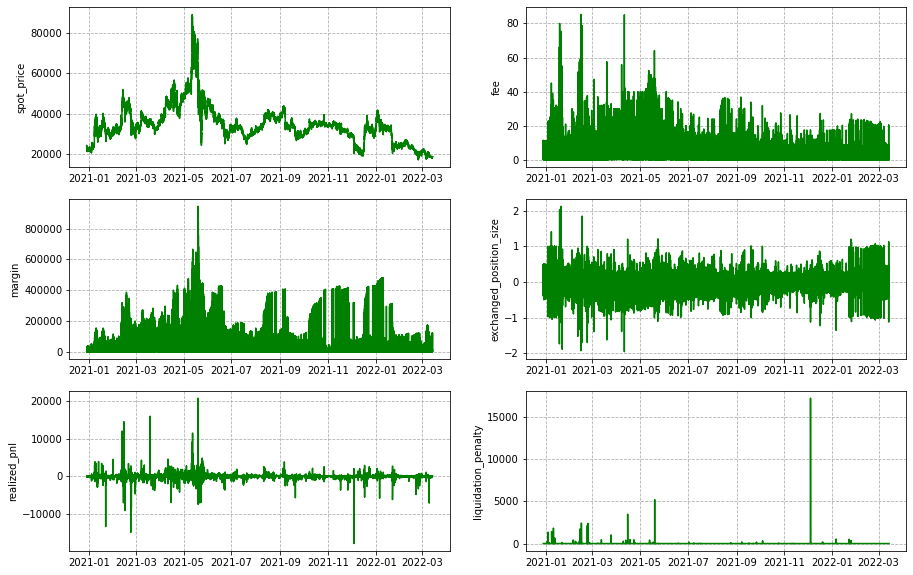

In [ ]:
plt.subplots(figsize=(15, 10))
index = 0
columns = ['spot_price', 'fee', 'margin', 'exchanged_position_size', 'realized_pnl', 'liquidation_penalty']
                                                                
for column in columns:
    ax = plt.subplot(3, 2, index + 1)
    ax.plot(position_changes_df[position_changes_df.amm_name == 'YFI/USDC'].timestamp,
            position_changes_df[position_changes_df.amm_name == 'YFI/USDC'][column],
            color='g')
    ax.set_ylabel(column)
    ax.grid(True, linestyle='--')
    index += 1

## ETH/USDC

In [ ]:
print('positive exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] > 0) &
                                                  (position_changes_df['amm_name'] == 'ETH/USDC')]['exchanged_position_size'])))
print('negative exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] < 0) &
                                                  (position_changes_df['amm_name'] == 'ETH/USDC')]['exchanged_position_size'])))

print('positive realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] > 0) &
                                                  (position_changes_df['amm_name'] == 'ETH/USDC')]['realized_pnl'])))
print('negative realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] < 0) &
                                                  (position_changes_df['amm_name'] == 'ETH/USDC')]['realized_pnl'])))

positive exchanged position size sum = 1579438.5726033447
negative exchanged position size sum = -1568928.7135377296
positive realized PnL sum = 41568034.878140196
negative realized PnL sum = -22413737.114851475


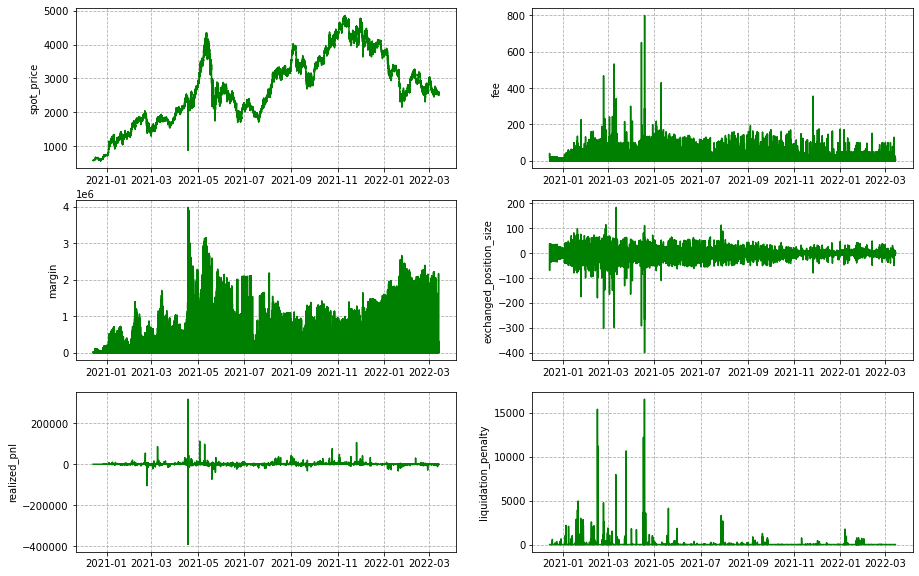

In [ ]:
plt.subplots(figsize=(15, 10))
index = 0
columns = ['spot_price', 'fee', 'margin', 'exchanged_position_size', 'realized_pnl', 'liquidation_penalty']

for column in columns:
    ax = plt.subplot(3, 2, index + 1)
    ax.plot(position_changes_df[position_changes_df.amm_name == 'ETH/USDC'].timestamp,
            position_changes_df[position_changes_df.amm_name == 'ETH/USDC'][column],
            color='g')
    ax.set_ylabel(column)
    ax.grid(True, linestyle='--')
    index += 1

## DOT/USDC

In [ ]:
print('positive exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] > 0) &
                                                  (position_changes_df['amm_name'] == 'DOT/USDC')]['exchanged_position_size'])))
print('negative exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] < 0) &
                                                  (position_changes_df['amm_name'] == 'DOT/USDC')]['exchanged_position_size'])))

print('positive realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] > 0) &
                                                  (position_changes_df['amm_name'] == 'DOT/USDC')]['realized_pnl'])))
print('negative realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] < 0) &
                                                  (position_changes_df['amm_name'] == 'DOT/USDC')]['realized_pnl'])))

positive exchanged position size sum = 50673090.65210002
negative exchanged position size sum = -50660454.446062066
positive realized PnL sum = 8362960.5696256505
negative realized PnL sum = -9262410.510966921


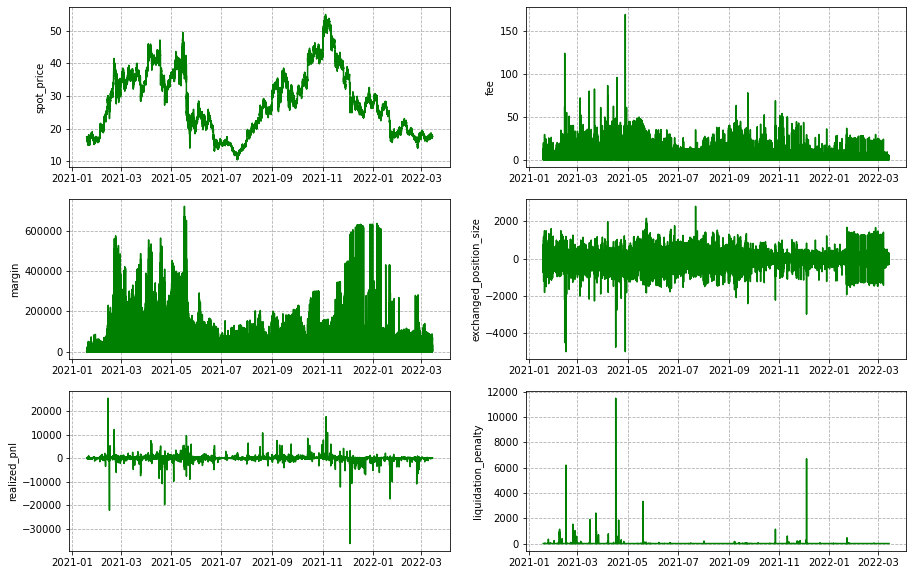

In [ ]:
plt.subplots(figsize=(15, 10))
index = 0
columns = ['spot_price', 'fee', 'margin', 'exchanged_position_size', 'realized_pnl', 'liquidation_penalty']

for column in columns:
    ax = plt.subplot(3, 2, index + 1)
    ax.plot(position_changes_df[position_changes_df.amm_name == 'DOT/USDC'].timestamp,
            position_changes_df[position_changes_df.amm_name == 'DOT/USDC'][column],
            color='g')
    ax.set_ylabel(column)
    ax.grid(True, linestyle='--')
    index += 1

## SNX/USDC

In [ ]:
print('positive exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] > 0) &
                                                  (position_changes_df['amm_name'] == 'SNX/USDC')]['exchanged_position_size'])))
print('negative exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] < 0) &
                                                  (position_changes_df['amm_name'] == 'SNX/USDC')]['exchanged_position_size'])))

print('positive realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] > 0) &
                                                  (position_changes_df['amm_name'] == 'SNX/USDC')]['realized_pnl'])))
print('negative realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] < 0) &
                                                  (position_changes_df['amm_name'] == 'SNX/USDC')]['realized_pnl'])))

positive exchanged position size sum = 71442589.85022236
negative exchanged position size sum = -71743150.95832483
positive realized PnL sum = 5233583.75183829
negative realized PnL sum = -4319126.828859696


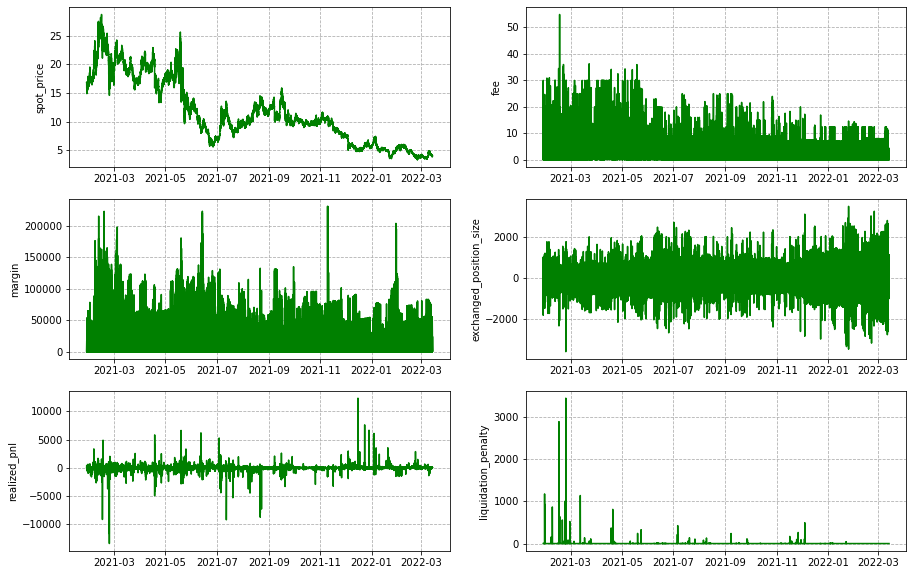

In [ ]:
plt.subplots(figsize=(15, 10))
index = 0
columns = ['spot_price', 'fee', 'margin', 'exchanged_position_size', 'realized_pnl', 'liquidation_penalty']

for column in columns:
    ax = plt.subplot(3, 2, index + 1)
    ax.plot(position_changes_df[position_changes_df.amm_name == 'SNX/USDC'].timestamp,
            position_changes_df[position_changes_df.amm_name == 'SNX/USDC'][column],
            color='g')
    ax.set_ylabel(column)
    ax.grid(True, linestyle='--')
    index += 1

## LINK/USDC

In [ ]:
print('positive exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] > 0) &
                                                  (position_changes_df['amm_name'] == 'LINK/USDC')]['exchanged_position_size'])))
print('negative exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] < 0) &
                                                  (position_changes_df['amm_name'] == 'LINK/USDC')]['exchanged_position_size'])))

print('positive realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] > 0) &
                                                  (position_changes_df['amm_name'] == 'LINK/USDC')]['realized_pnl'])))
print('negative realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] < 0) &
                                                  (position_changes_df['amm_name'] == 'LINK/USDC')]['realized_pnl'])))

positive exchanged position size sum = 47997015.448344976
negative exchanged position size sum = -48124355.760847606
positive realized PnL sum = 7243059.7439518375
negative realized PnL sum = -6782865.139458948


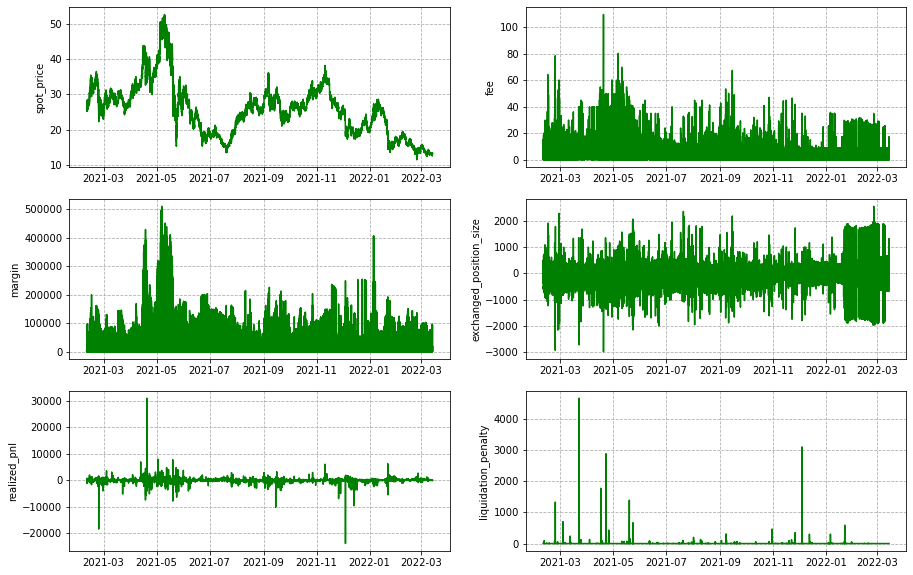

In [ ]:
plt.subplots(figsize=(15, 10))
index = 0
columns = ['spot_price', 'fee', 'margin', 'exchanged_position_size', 'realized_pnl', 'liquidation_penalty']

for column in columns:
    ax = plt.subplot(3, 2, index + 1)
    ax.plot(position_changes_df[position_changes_df.amm_name == 'LINK/USDC'].timestamp,
            position_changes_df[position_changes_df.amm_name == 'LINK/USDC'][column],
            color='g')
    ax.set_ylabel(column)
    ax.grid(True, linestyle='--')
    index += 1

## AAVE/USDC

In [ ]:
print('positive exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] > 0) &
                                                  (position_changes_df['amm_name'] == 'AAVE/USDC')]['exchanged_position_size'])))
print('negative exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] < 0) &
                                                  (position_changes_df['amm_name'] == 'AAVE/USDC')]['exchanged_position_size'])))

print('positive realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] > 0) &
                                                  (position_changes_df['amm_name'] == 'AAVE/USDC')]['realized_pnl'])))
print('negative realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] < 0) &
                                                  (position_changes_df['amm_name'] == 'AAVE/USDC')]['realized_pnl'])))

positive exchanged position size sum = 3716643.6508570374
negative exchanged position size sum = -3733397.371818556
positive realized PnL sum = 7406027.655380865
negative realized PnL sum = -6803827.5390379


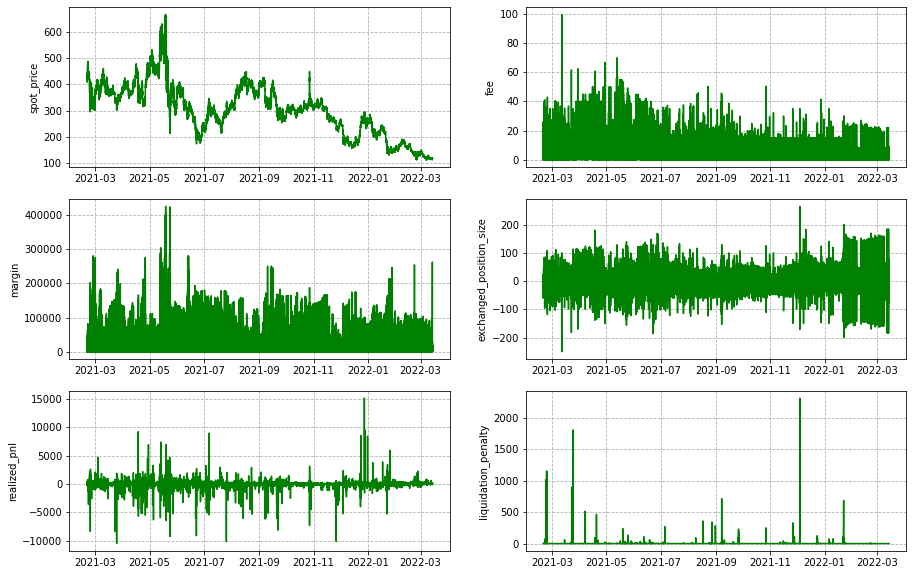

In [ ]:
plt.subplots(figsize=(15, 10))
index = 0
columns = ['spot_price', 'fee', 'margin', 'exchanged_position_size', 'realized_pnl', 'liquidation_penalty']

for column in columns:
    ax = plt.subplot(3, 2, index + 1)
    ax.plot(position_changes_df[position_changes_df.amm_name == 'AAVE/USDC'].timestamp,
            position_changes_df[position_changes_df.amm_name == 'AAVE/USDC'][column],
            color='g')
    ax.set_ylabel(column)
    ax.grid(True, linestyle='--')
    index += 1

## SUSHI/USDC

In [ ]:
print('positive exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] > 0) &
                                                  (position_changes_df['amm_name'] == 'SUSHI/USDC')]['exchanged_position_size'])))
print('negative exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] < 0) &
                                                  (position_changes_df['amm_name'] == 'SUSHI/USDC')]['exchanged_position_size'])))

print('positive realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] > 0) &
                                                  (position_changes_df['amm_name'] == 'SUSHI/USDC')]['realized_pnl'])))
print('negative realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] < 0) &
                                                  (position_changes_df['amm_name'] == 'SUSHI/USDC')]['realized_pnl'])))

positive exchanged position size sum = 112334983.96298216
negative exchanged position size sum = -113010550.76316297
positive realized PnL sum = 7961983.650406382
negative realized PnL sum = -7015674.941398151


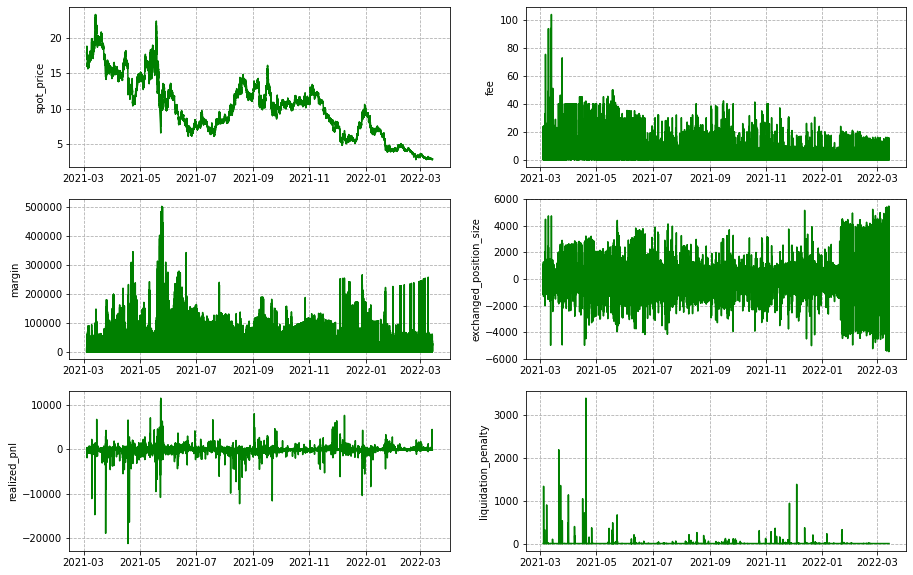

In [ ]:
plt.subplots(figsize=(15, 10))
index = 0
columns = ['spot_price', 'fee', 'margin', 'exchanged_position_size', 'realized_pnl', 'liquidation_penalty']

for column in columns:
    ax = plt.subplot(3, 2, index + 1)
    ax.plot(position_changes_df[position_changes_df.amm_name == 'SUSHI/USDC'].timestamp,
            position_changes_df[position_changes_df.amm_name == 'SUSHI/USDC'][column],
            color='g')
    ax.set_ylabel(column)
    ax.grid(True, linestyle='--')
    index += 1

## COMP/USDC

In [ ]:
print('positive exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] > 0) &
                                                  (position_changes_df['amm_name'] == 'COMP/USDC')]['exchanged_position_size'])))
print('negative exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] < 0) &
                                                  (position_changes_df['amm_name'] == 'COMP/USDC')]['exchanged_position_size'])))

print('positive realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] > 0) &
                                                  (position_changes_df['amm_name'] == 'COMP/USDC')]['realized_pnl'])))
print('negative realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] < 0) &
                                                  (position_changes_df['amm_name'] == 'COMP/USDC')]['realized_pnl'])))

positive exchanged position size sum = 2922581.870851445
negative exchanged position size sum = -2942493.910811919
positive realized PnL sum = 6035367.785976909
negative realized PnL sum = -5218947.699393308


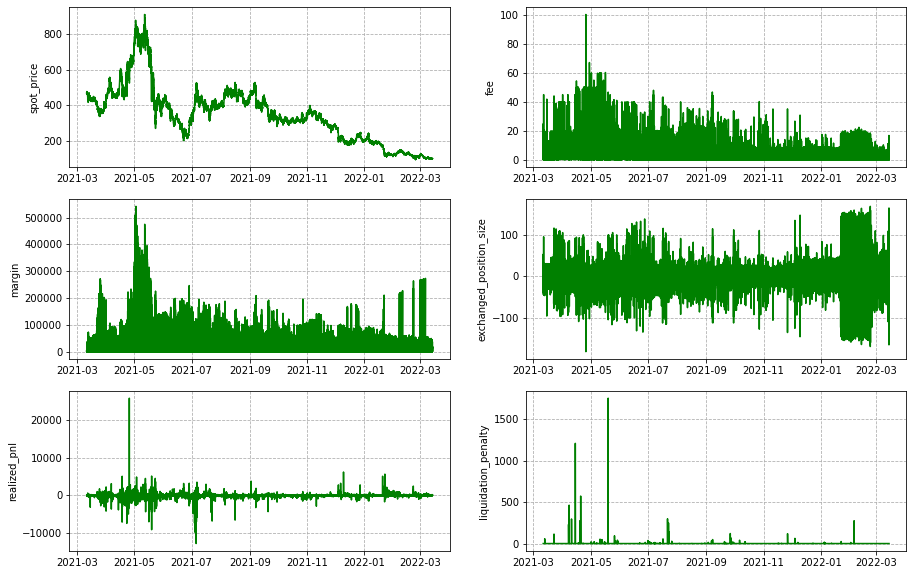

In [ ]:
plt.subplots(figsize=(15, 10))
index = 0
columns = ['spot_price', 'fee', 'margin', 'exchanged_position_size', 'realized_pnl', 'liquidation_penalty']

for column in columns:
    ax = plt.subplot(3, 2, index + 1)
    ax.plot(position_changes_df[position_changes_df.amm_name == 'COMP/USDC'].timestamp,
            position_changes_df[position_changes_df.amm_name == 'COMP/USDC'][column],
            color='g')
    ax.set_ylabel(column)
    ax.grid(True, linestyle='--')
    index += 1

## REN/USDC

In [ ]:
print('positive exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] > 0) &
                                                  (position_changes_df['amm_name'] == 'REN/USDC')]['exchanged_position_size'])))
print('negative exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] < 0) &
                                                  (position_changes_df['amm_name'] == 'REN/USDC')]['exchanged_position_size'])))

print('positive realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] > 0) &
                                                  (position_changes_df['amm_name'] == 'REN/USDC')]['realized_pnl'])))
print('negative realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] < 0) &
                                                  (position_changes_df['amm_name'] == 'REN/USDC')]['realized_pnl'])))

positive exchanged position size sum = 1545107717.790753
negative exchanged position size sum = -1550398085.975341
positive realized PnL sum = 7055259.058424884
negative realized PnL sum = -5908308.31466894


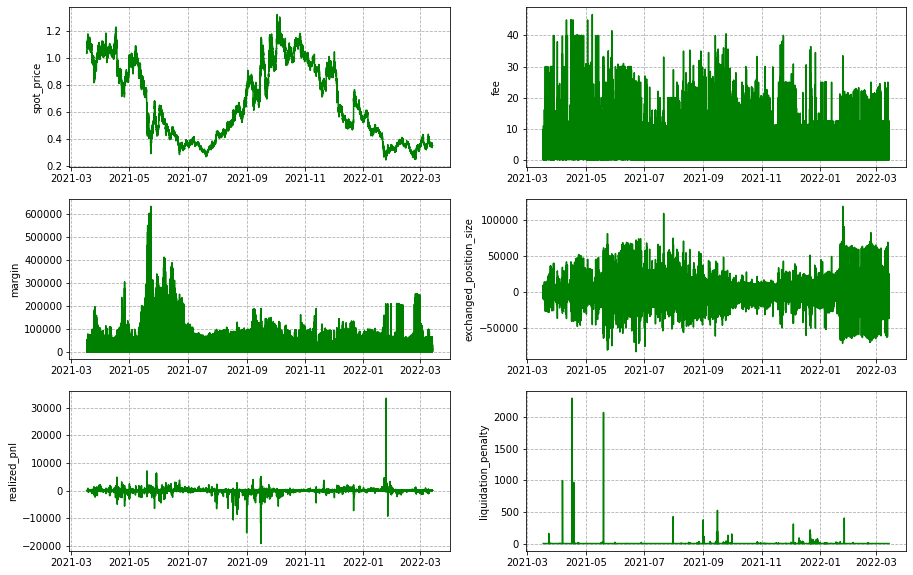

In [ ]:
plt.subplots(figsize=(15, 10))
index = 0
columns = ['spot_price', 'fee', 'margin', 'exchanged_position_size', 'realized_pnl', 'liquidation_penalty']

for column in columns:
    ax = plt.subplot(3, 2, index + 1)
    ax.plot(position_changes_df[position_changes_df.amm_name == 'REN/USDC'].timestamp,
            position_changes_df[position_changes_df.amm_name == 'REN/USDC'][column],
            color='g')
    ax.set_ylabel(column)
    ax.grid(True, linestyle='--')
    index += 1

## PERP/USDC

In [ ]:
print('positive exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] > 0) &
                                                  (position_changes_df['amm_name'] == 'PERP/USDC')]['exchanged_position_size'])))
print('negative exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] < 0) &
                                                  (position_changes_df['amm_name'] == 'PERP/USDC')]['exchanged_position_size'])))

print('positive realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] > 0) &
                                                  (position_changes_df['amm_name'] == 'PERP/USDC')]['realized_pnl'])))
print('negative realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] < 0) &
                                                  (position_changes_df['amm_name'] == 'PERP/USDC')]['realized_pnl'])))

positive exchanged position size sum = 100809369.68919997
negative exchanged position size sum = -101252708.61779769
positive realized PnL sum = 10143802.909568166
negative realized PnL sum = -9636058.302435886


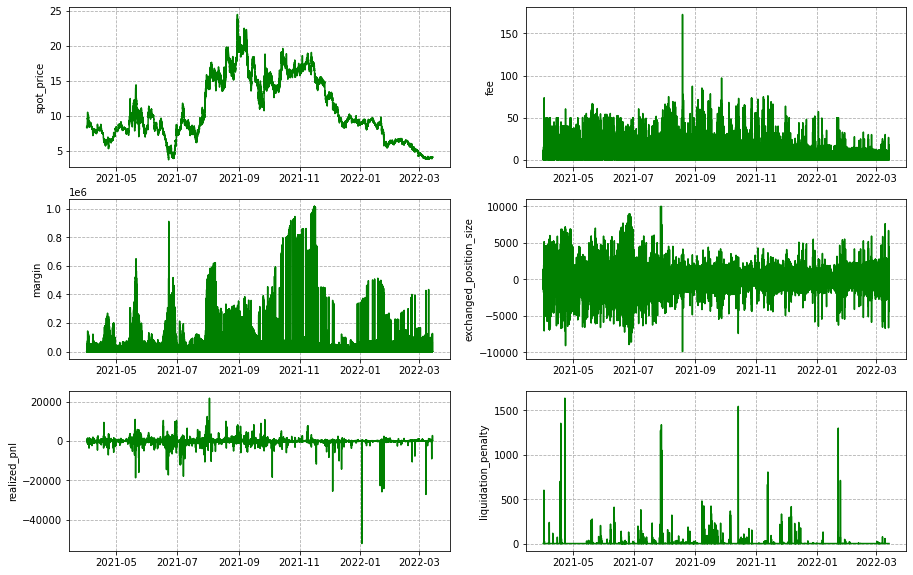

In [ ]:
plt.subplots(figsize=(15, 10))
index = 0
columns = ['spot_price', 'fee', 'margin', 'exchanged_position_size', 'realized_pnl', 'liquidation_penalty']

for column in columns:
    ax = plt.subplot(3, 2, index + 1)
    ax.plot(position_changes_df[position_changes_df.amm_name == 'PERP/USDC'].timestamp,
            position_changes_df[position_changes_df.amm_name == 'PERP/USDC'][column],
            color='g')
    ax.set_ylabel(column)
    ax.grid(True, linestyle='--')
    index += 1

## UNI/USDC

In [ ]:
print('positive exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] > 0) &
                                                  (position_changes_df['amm_name'] == 'UNI/USDC')]['exchanged_position_size'])))
print('negative exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] < 0) &
                                                  (position_changes_df['amm_name'] == 'UNI/USDC')]['exchanged_position_size'])))

print('positive realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] > 0) &
                                                  (position_changes_df['amm_name'] == 'UNI/USDC')]['realized_pnl'])))
print('negative realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] < 0) &
                                                  (position_changes_df['amm_name'] == 'UNI/USDC')]['realized_pnl'])))

positive exchanged position size sum = 42459923.37442487
negative exchanged position size sum = -42697001.61310094
positive realized PnL sum = 5356147.187199321
negative realized PnL sum = -4688592.545813933


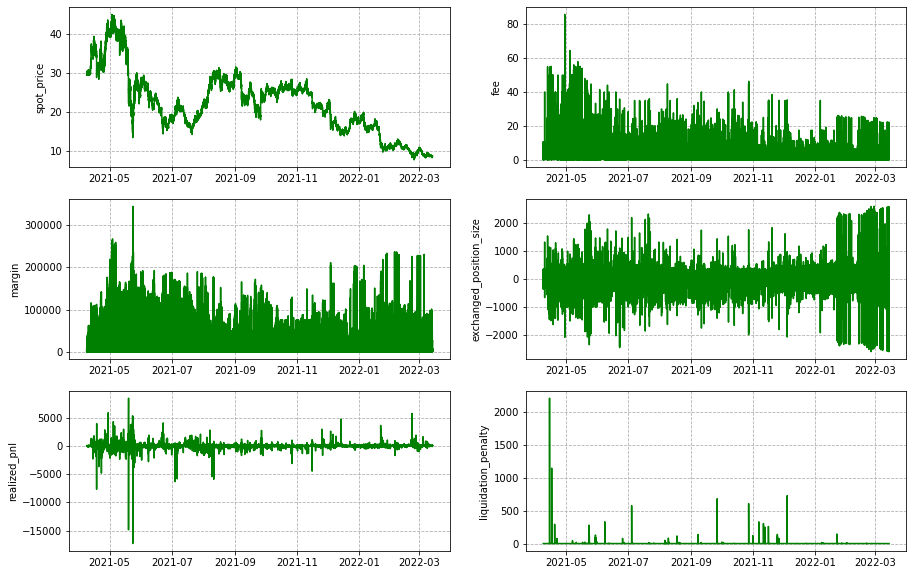

In [ ]:
plt.subplots(figsize=(15, 10))
index = 0
columns = ['spot_price', 'fee', 'margin', 'exchanged_position_size', 'realized_pnl', 'liquidation_penalty']

for column in columns:
    ax = plt.subplot(3, 2, index + 1)
    ax.plot(position_changes_df[position_changes_df.amm_name == 'UNI/USDC'].timestamp,
            position_changes_df[position_changes_df.amm_name == 'UNI/USDC'][column],
            color='g')
    ax.set_ylabel(column)
    ax.grid(True, linestyle='--')
    index += 1

## CRV/USDC

In [ ]:
print('positive exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] > 0) &
                                                  (position_changes_df['amm_name'] == 'CRV/USDC')]['exchanged_position_size'])))
print('negative exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] < 0) &
                                                  (position_changes_df['amm_name'] == 'CRV/USDC')]['exchanged_position_size'])))

print('positive realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] > 0) &
                                                  (position_changes_df['amm_name'] == 'CRV/USDC')]['realized_pnl'])))
print('negative realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] < 0) &
                                                  (position_changes_df['amm_name'] == 'CRV/USDC')]['realized_pnl'])))

positive exchanged position size sum = 489670063.6201976
negative exchanged position size sum = -490275063.8672339
positive realized PnL sum = 9971438.953435108
negative realized PnL sum = -10241737.350984568


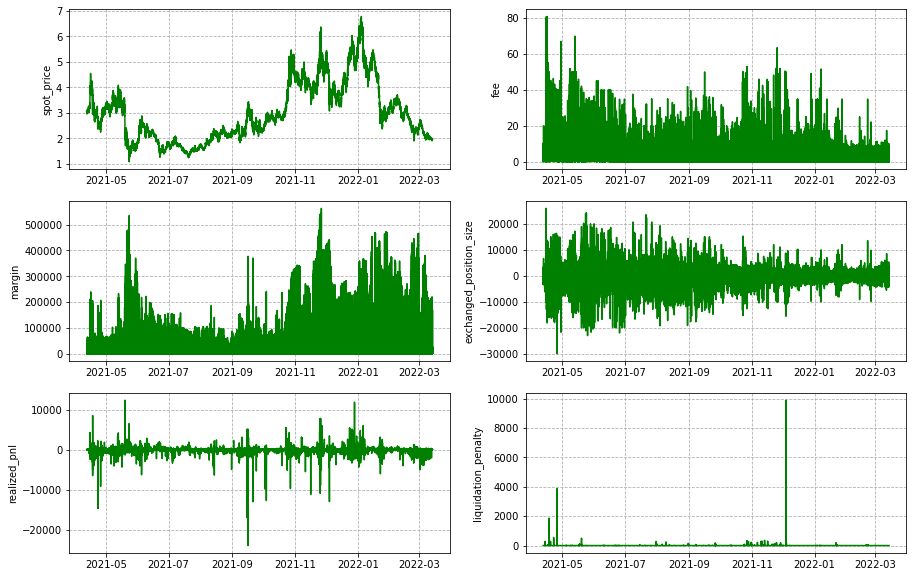

In [ ]:
plt.subplots(figsize=(15, 10))
index = 0
columns = ['spot_price', 'fee', 'margin', 'exchanged_position_size', 'realized_pnl', 'liquidation_penalty']

for column in columns:
    ax = plt.subplot(3, 2, index + 1)
    ax.plot(position_changes_df[position_changes_df.amm_name == 'CRV/USDC'].timestamp,
            position_changes_df[position_changes_df.amm_name == 'CRV/USDC'][column],
            color='g')
    ax.set_ylabel(column)
    ax.grid(True, linestyle='--')
    index += 1

## MKR/USDC

In [ ]:
print('positive exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] > 0) &
                                                  (position_changes_df['amm_name'] == 'MKR/USDC')]['exchanged_position_size'])))
print('negative exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] < 0) &
                                                  (position_changes_df['amm_name'] == 'MKR/USDC')]['exchanged_position_size'])))

print('positive realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] > 0) &
                                                  (position_changes_df['amm_name'] == 'MKR/USDC')]['realized_pnl'])))
print('negative realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] < 0) &
                                                  (position_changes_df['amm_name'] == 'MKR/USDC')]['realized_pnl'])))

positive exchanged position size sum = 197431.54442931226
negative exchanged position size sum = -198620.87617357934
positive realized PnL sum = 3854651.6112479335
negative realized PnL sum = -3250462.0426783664


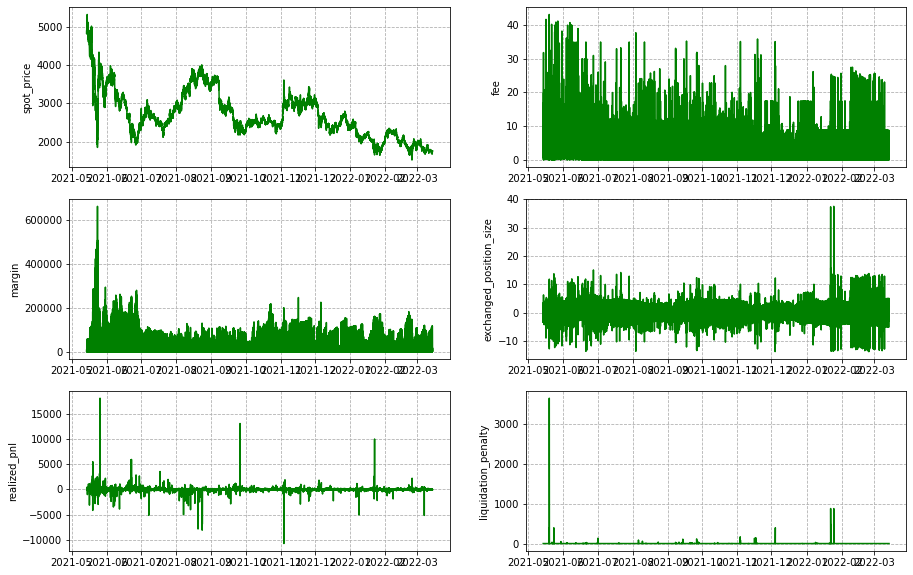

In [ ]:
plt.subplots(figsize=(15, 10))
index = 0
columns = ['spot_price', 'fee', 'margin', 'exchanged_position_size', 'realized_pnl', 'liquidation_penalty']

for column in columns:
    ax = plt.subplot(3, 2, index + 1)
    ax.plot(position_changes_df[position_changes_df.amm_name == 'MKR/USDC'].timestamp,
            position_changes_df[position_changes_df.amm_name == 'MKR/USDC'][column],
            color='g')
    ax.set_ylabel(column)
    ax.grid(True, linestyle='--')
    index += 1

## CREAM/USDC

In [ ]:
print('positive exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] > 0) &
                                                  (position_changes_df['amm_name'] == 'CREAM/USDC')]['exchanged_position_size'])))
print('negative exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] < 0) &
                                                  (position_changes_df['amm_name'] == 'CREAM/USDC')]['exchanged_position_size'])))

print('positive realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] > 0) &
                                                  (position_changes_df['amm_name'] == 'CREAM/USDC')]['realized_pnl'])))
print('negative realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] < 0) &
                                                  (position_changes_df['amm_name'] == 'CREAM/USDC')]['realized_pnl'])))

positive exchanged position size sum = 8304548.974014788
negative exchanged position size sum = -8348172.487696608
positive realized PnL sum = 6464817.700931226
negative realized PnL sum = -5287323.756388757


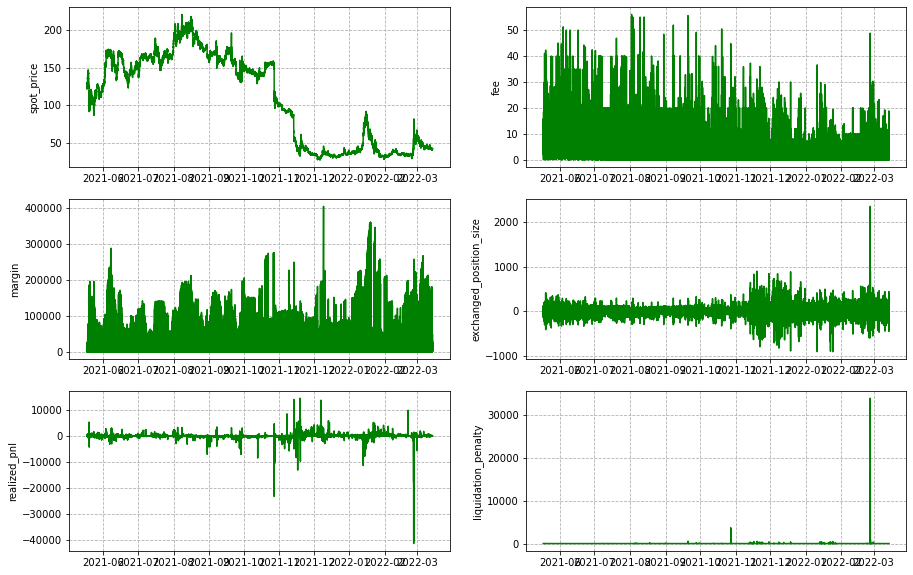

In [ ]:
plt.subplots(figsize=(15, 10))
index = 0
columns = ['spot_price', 'fee', 'margin', 'exchanged_position_size', 'realized_pnl', 'liquidation_penalty']

for column in columns:
    ax = plt.subplot(3, 2, index + 1)
    ax.plot(position_changes_df[position_changes_df.amm_name == 'CREAM/USDC'].timestamp,
            position_changes_df[position_changes_df.amm_name == 'CREAM/USDC'][column],
            color='g')
    ax.set_ylabel(column)
    ax.grid(True, linestyle='--')
    index += 1

## GRT/USDC

In [ ]:
print('positive exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] > 0) &
                                                  (position_changes_df['amm_name'] == 'GRT/USDC')]['exchanged_position_size'])))
print('negative exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] < 0) &
                                                  (position_changes_df['amm_name'] == 'GRT/USDC')]['exchanged_position_size'])))

print('positive realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] > 0) &
                                                  (position_changes_df['amm_name'] == 'GRT/USDC')]['realized_pnl'])))
print('negative realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] < 0) &
                                                  (position_changes_df['amm_name'] == 'GRT/USDC')]['realized_pnl'])))

positive exchanged position size sum = 1200576740.6709335
negative exchanged position size sum = -1205376749.9435596
positive realized PnL sum = 4599686.787681896
negative realized PnL sum = -4433692.411048995


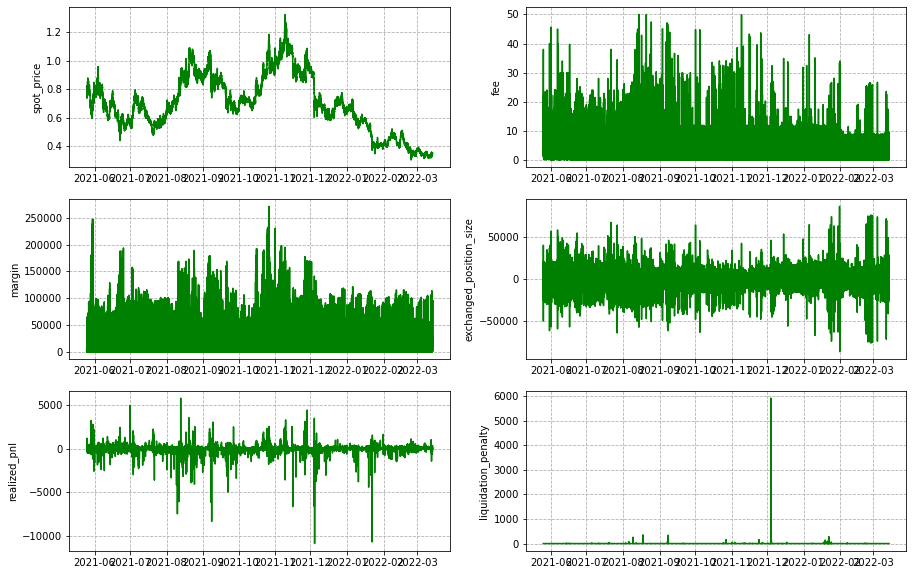

In [ ]:
plt.subplots(figsize=(15, 10))
index = 0
columns = ['spot_price', 'fee', 'margin', 'exchanged_position_size', 'realized_pnl', 'liquidation_penalty']

for column in columns:
    ax = plt.subplot(3, 2, index + 1)
    ax.plot(position_changes_df[position_changes_df.amm_name == 'GRT/USDC'].timestamp,
            position_changes_df[position_changes_df.amm_name == 'GRT/USDC'][column],
            color='g')
    ax.set_ylabel(column)
    ax.grid(True, linestyle='--')
    index += 1

## ALPHA/USDC

In [ ]:
print('positive exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] > 0) &
                                                  (position_changes_df['amm_name'] == 'ALPHA/USDC')]['exchanged_position_size'])))
print('negative exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] < 0) &
                                                  (position_changes_df['amm_name'] == 'ALPHA/USDC')]['exchanged_position_size'])))

print('positive realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] > 0) &
                                                  (position_changes_df['amm_name'] == 'ALPHA/USDC')]['realized_pnl'])))
print('negative realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] < 0) &
                                                  (position_changes_df['amm_name'] == 'ALPHA/USDC')]['realized_pnl'])))

positive exchanged position size sum = 1078049842.4075632
negative exchanged position size sum = -1085767998.846283
positive realized PnL sum = 4828880.563959291
negative realized PnL sum = -4640864.13468609


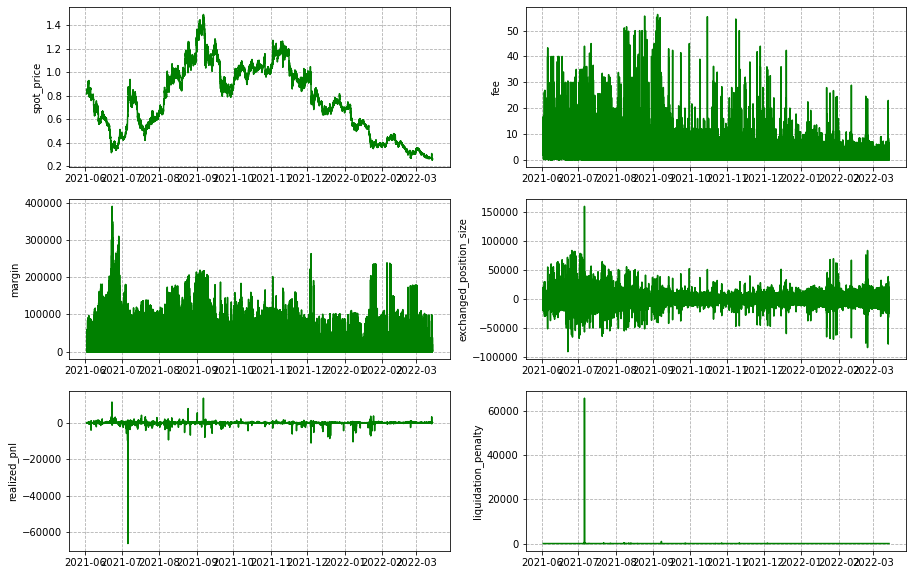

In [ ]:
plt.subplots(figsize=(15, 10))
index = 0
columns = ['spot_price', 'fee', 'margin', 'exchanged_position_size', 'realized_pnl', 'liquidation_penalty']

for column in columns:
    ax = plt.subplot(3, 2, index + 1)
    ax.plot(position_changes_df[position_changes_df.amm_name == 'ALPHA/USDC'].timestamp,
            position_changes_df[position_changes_df.amm_name == 'ALPHA/USDC'][column],
            color='g')
    ax.set_ylabel(column)
    ax.grid(True, linestyle='--')
    index += 1

## FTT/USDC

In [ ]:
print('positive exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] > 0) &
                                                  (position_changes_df['amm_name'] == 'FTT/USDC')]['exchanged_position_size'])))
print('negative exchanged position size sum = ' + str(sum(position_changes_df[(position_changes_df['exchanged_position_size'] < 0) &
                                                  (position_changes_df['amm_name'] == 'FTT/USDC')]['exchanged_position_size'])))

print('positive realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] > 0) &
                                                  (position_changes_df['amm_name'] == 'FTT/USDC')]['realized_pnl'])))
print('negative realized PnL sum = ' + str(sum(position_changes_df[(position_changes_df['realized_pnl'] < 0) &
                                                  (position_changes_df['amm_name'] == 'FTT/USDC')]['realized_pnl'])))

positive exchanged position size sum = 10137972.688465387
negative exchanged position size sum = -10105793.164640201
positive realized PnL sum = 3977991.9487679126
negative realized PnL sum = -3651056.0212416975


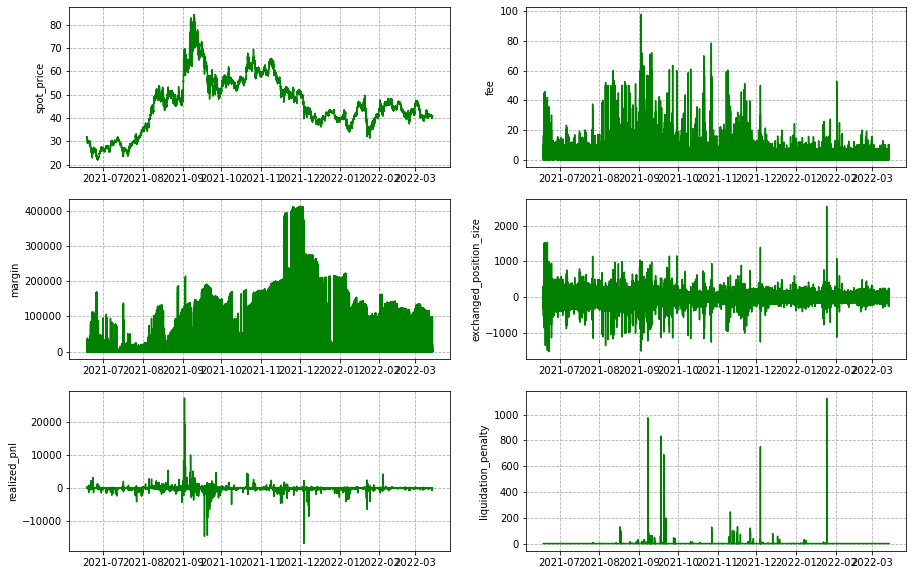

In [ ]:
plt.subplots(figsize=(15, 10))
index = 0
columns = ['spot_price', 'fee', 'margin', 'exchanged_position_size', 'realized_pnl', 'liquidation_penalty']

for column in columns:
    ax = plt.subplot(3, 2, index + 1)
    ax.plot(position_changes_df[position_changes_df.amm_name == 'FTT/USDC'].timestamp,
            position_changes_df[position_changes_df.amm_name == 'FTT/USDC'][column],
            color='g')
    ax.set_ylabel(column)
    ax.grid(True, linestyle='--')
    index += 1